In [109]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)

df = pd.read_csv('data/processed_headlines_locations.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head(10)

,headline,city,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US
5,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO
6,Zika Concerns are Spreading in Houston,Houston,29.76328,-95.36327,US
7,Geneve Scientists Battle to Find Cure,Geneve,46.20222,6.14569,CH
8,The CDC in Atlanta is Growing Worried,Atlanta,33.74900,-84.38798,US
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,-23.54750,-46.63611,BR


In [190]:
### Split up US vs. World

us_headlines = df[df['countrycode'] == 'US']
us_headlines.head(10)

,headline,city,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US
6,Zika Concerns are Spreading in Houston,Houston,29.76328,-95.36327,US
8,The CDC in Atlanta is Growing Worried,Atlanta,33.74900,-84.38798,US
10,Brownsville teen contracts Zika virus,Brownsville,25.90175,-97.49748,US
11,Mosquito control efforts in St. Louis take new...,St. Louis,38.62727,-90.19789,US
13,"Flu outbreak in Galveston, Texas",Galveston,29.30135,-94.79770,US
17,Orlando volunteers aid Zika research,Orlando,28.53834,-81.37924,US


In [111]:
world_headlines = df[df['countrycode'] != 'US']
world_headlines.head(10)

,headline,city,latitude,longitude,countrycode
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
5,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO
7,Geneve Scientists Battle to Find Cure,Geneve,46.20222,6.14569,CH
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,-23.54750,-46.63611,BR
12,San Juan reports 1st U.S. Zika-related death a...,San Juan,-31.53750,-68.53639,AR
14,Zika alert - Manila now threatened,Manila,14.60420,120.98220,PH
15,Zika afflicts 7 in Iloilo City,Iloilo,10.69694,122.56444,PH
16,New Los Angeles Hairstyle goes Viral,Los Angeles,-37.46973,-72.35366,CL
22,London Health Unit Tracks Mad Cow Disease,London,51.50853,-0.12574,GB
23,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,10.82302,106.62965,VN


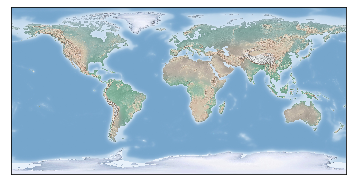

In [112]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

plt.rcParams['font.size'] = 18

%matplotlib inline

# simple world map
basemap = Basemap()
_ = basemap.shadedrelief()

In [113]:


def cluster_location(clusterer, data, lat_string="latitude", lng_string="longitude"):
    """
    Fit a clustering algorithm on location data.
    from section 3 solution
    """
    features = data[[lat_string, lng_string]].copy()
    clusterer.fit(features)
    # Assign the cluster labels
    data["cluster"] = clusterer.labels_
    return data

def plot_clusters(data, x="longitude", y="latitude"):
    """
    Plot clustered data on a basemap.
    from section 3 solution
    """
    plt.figure(figsize=(16,10))
    basemap.shadedrelief()
    
    # iterate through each cluster and plot
    for cluster, grouped in data.groupby("cluster"):
        if cluster == -1:
            # handle the unassigned headlines
            plt.scatter(
                grouped[x],
                grouped[y],
                s=60,
                alpha=0.8,
                marker="o",
                label=f"Cluster: None",
                c="k",
            )
        else:
            plt.scatter(
                grouped[x],
                grouped[y],
                s=60,
                alpha=0.8,
                marker="o",
                label=f"Cluster: {cluster}",
            )
    
    # add a legend and title (put legend to the right of the plot)
    ax = plt.gca()
    ax.legend(loc=(1,0))
    _ = ax.set_title("Locations of Headlines", size=20)

In [132]:
def generateCluster(dataset, clusters):
    """
    Function to quickly generate clustered datasets
    """
    kmeans_clusterer = KMeans(n_clusters = clusters)
    data = cluster_location(kmeans_clusterer, dataset)
    data = data.reset_index(level=0)
    data["count"] = data.groupby(["cluster"])["index"].transform("count")
    plot_clusters(data)
    return data

In [159]:
import math

### find geographic middle of a cluster
def geographic_middle(dataset):
    x = 0.0
    y = 0.0
    z = 0.0
    
    for idx, row in dataset.iterrows():
        latitude = math.radians(row.latitude)
        longitude = math.radians(row.longitude)
        x += math.cos(latitude) * math.cos(longitude)
        y += math.cos(latitude) * math.sin(longitude)
        z += math.sin(latitude)
    
    total = len(dataset)
    
    x = x / total
    y = y / total
    z = z / total
    
    central_longitude = math.atan2(y, x)
    central_square_root = math.sqrt(x * x + y * y)
    central_latitude = math.atan2(z, central_square_root)
    
    return {'latitude': math.degrees(central_latitude),
            'longitude': math.degrees(central_longitude)}

In [183]:
import numpy as np

def distance_from_center(row, center):
    x1, x2 = math.radians(row['latitude']), math.radians(center['latitude'])
    y1, y2 = math.radians(row['longitude']), math.radians(center['longitude'])
    delta_x, delta_y = x2 - x1, y2 - y1
    haversin = math.sin(delta_x / 2) ** 2 + np.product([math.cos(x1), math.cos(x2), math.sin(delta_y / 2) ** 2])
    
    return (2 * math.asin(haversin ** 0.5)) * 3956

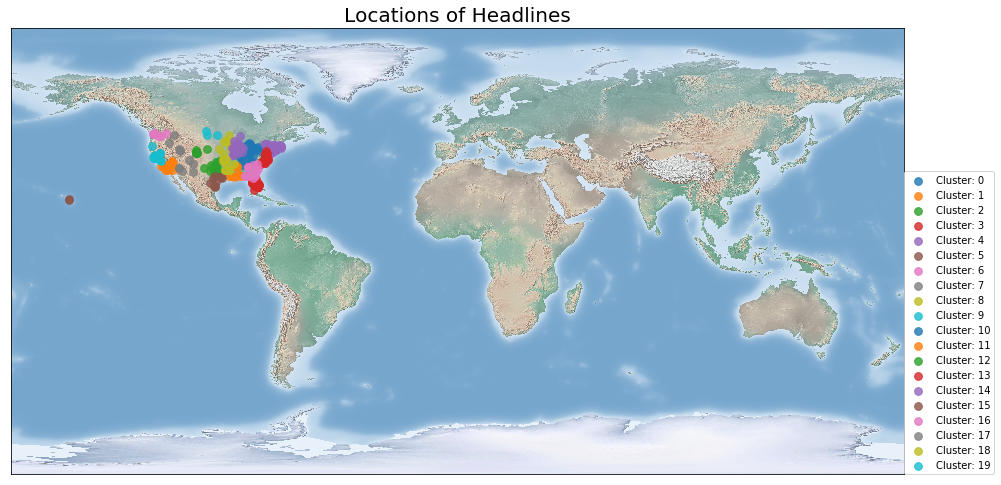

In [191]:
us_clusters = generateCluster(us_headlines, 20)

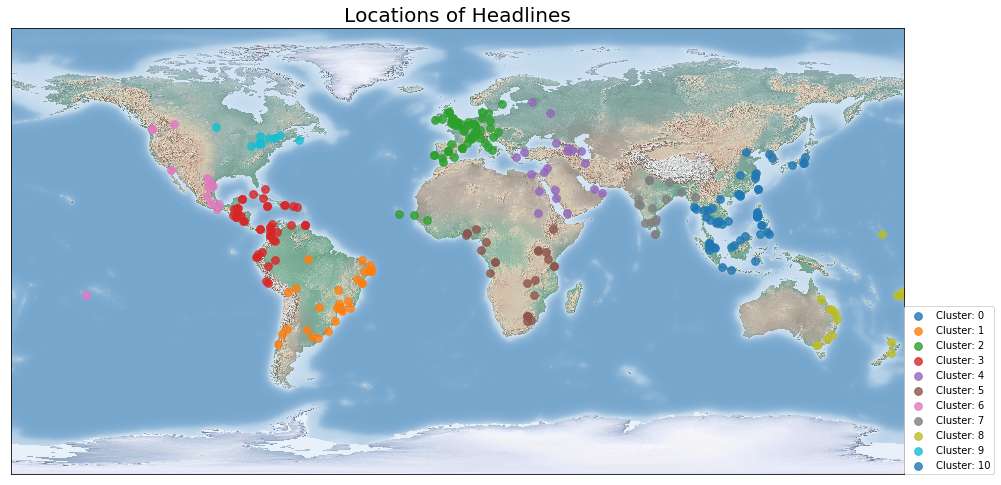

In [207]:
world_clusters = generateCluster(world_headlines, 11)

In [192]:
us_clusters.head(10).sort_values(by=["count"], ascending=False)

,index,headline,city,latitude,longitude,countrycode,cluster,count
1,1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US,4,46
0,0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US,3,35
2,2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US,3,35
9,17,Orlando volunteers aid Zika research,Orlando,28.53834,-81.37924,US,3,35
7,11,Mosquito control efforts in St. Louis take new...,St. Louis,38.62727,-90.19789,US,14,20
3,4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US,2,16
5,8,The CDC in Atlanta is Growing Worried,Atlanta,33.74900,-84.38798,US,16,13
4,6,Zika Concerns are Spreading in Houston,Houston,29.76328,-95.36327,US,15,10
6,10,Brownsville teen contracts Zika virus,Brownsville,25.90175,-97.49748,US,15,10
8,13,"Flu outbreak in Galveston, Texas",Galveston,29.30135,-94.79770,US,15,10


In [203]:
us_clusters["count"].unique()

array([35, 46, 16, 10, 13, 20, 15, 25, 32, 22,  7,  8,  6,  5, 12,  2,  3])

In [204]:
largest_cluster = us_clusters[us_clusters['count'] == 35]
center_point = geographic_middle(largest_cluster)
print(center_point)
largest_cluster['dist_from_center'] = largest_cluster.apply(distance_from_center, center=(center_point), axis=1)

{'latitude': 26.804177681814952, 'longitude': -80.95887977940079}


In [205]:
largest_cluster.sort_values(by=["dist_from_center"], ascending=True)

,index,headline,city,latitude,longitude,countrycode,cluster,count,dist_from_center
124,275,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,26.82339,-80.13865,US,3,35,50.560940
46,132,Zika case reported in Jupiter,Jupiter,26.93422,-80.09421,US,3,35,54.007476
175,375,More Zika patients reported in Fort Myers,Fort Myers,26.62168,-81.84059,US,3,35,55.821007
92,207,Zika arrives in West Palm Beach,West Palm Beach,26.71534,-80.05337,US,3,35,56.161096
301,600,Zika symptoms spotted in Boynton Beach,Boynton Beach,26.52535,-80.06643,US,3,35,58.334146
214,439,Zika reported in Fort Pierce,Fort Pierce,27.44671,-80.32561,US,3,35,59.012665
290,580,Zika Troubles come to Delray Beach,Delray Beach,26.46146,-80.07282,US,3,35,59.586775
147,324,Zika in Tamarac!,Tamarac,26.21286,-80.24977,US,3,35,59.887143
174,373,Zika symptoms spotted in Bonita Springs,Bonita Springs,26.33981,-81.77870,US,3,35,59.924309
200,419,Zika arrives in Boca Raton,Boca Raton,26.35869,-80.08310,US,3,35,62.212321


### Zika Found in Florida

## Now do the world

In [208]:
world_clusters.head(10).sort_values(by=["count"], ascending=False)

,index,headline,city,latitude,longitude,countrycode,cluster,count
2,7,Geneve Scientists Battle to Find Cure,Geneve,46.20222,6.14569,CH,2,65
8,22,London Health Unit Tracks Mad Cow Disease,London,51.50853,-0.12574,GB,2,65
5,14,Zika alert - Manila now threatened,Manila,14.60420,120.98220,PH,0,36
6,15,Zika afflicts 7 in Iloilo City,Iloilo,10.69694,122.56444,PH,0,36
0,3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR,1,31
1,5,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO,1,31
3,9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,-23.54750,-46.63611,BR,1,31
4,12,San Juan reports 1st U.S. Zika-related death a...,San Juan,-31.53750,-68.53639,AR,1,31
7,16,New Los Angeles Hairstyle goes Viral,Los Angeles,-37.46973,-72.35366,CL,1,31
9,23,Zika cases in Vietnam's Ho Chi Minh City surge,Ho Chi Minh City,10.82302,106.62965,VN,10,27


In [209]:
world_clusters["count"].unique()

array([31, 65, 36, 27, 15, 45, 12, 13, 24, 17, 20])

In [212]:
largest_cluster = world_clusters[world_clusters['count'] == 45]
center_point = geographic_middle(largest_cluster)
print(center_point)
largest_cluster['dist_from_center'] = largest_cluster.apply(distance_from_center, center=(center_point), axis=1)

{'latitude': 10.550987873333192, 'longitude': -78.04871920279514}


In [213]:
largest_cluster.sort_values(by=["dist_from_center"], ascending=True)

,index,headline,city,latitude,longitude,countrycode,cluster,count,dist_from_center
138,259,Tocumen tests new cure for Hepatitis A,Tocumen,9.08939,-79.38310,PA,3,45,135.739118
162,296,Rotavirus Vaccine is now Required in Las Cumbres,Las Cumbres,9.08916,-79.52809,PA,3,45,142.535961
264,511,Zika arrives in San Onofre,San Onofre,9.73586,-75.52626,CO,3,45,180.441240
168,307,Zika Outbreak in Sincelejo,Sincelejo,9.30472,-75.39778,CO,3,45,199.771644
140,262,Zika spreads to Barranquilla,Barranquilla,10.96854,-74.78132,CO,3,45,223.497644
279,553,Zika spreads to Caucasia,Caucasia,7.98654,-75.19349,CO,3,45,263.059254
116,215,Zika symptoms spotted in Bello,Bello,6.33732,-75.55795,CO,3,45,336.995956
263,506,Zika case reported in Medellin,Medellin,6.25184,-75.56359,CO,3,45,341.921401
48,80,Visitor to Cucuta contracts Zika,Cucuta,7.89391,-72.50782,CO,3,45,419.796369
23,45,18 new Zika Cases in Bogota,Bogota,4.60971,-74.08175,CO,3,45,491.857327


### Zika in South America